# Importing libs and loding data

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

In [ ]:
root_path = "/content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/"

In [ ]:
data_file = "/content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/data.csv"
data = pd.read_csv(data_file)
data.head()

,f1,f2,label
0,0.450564,1.074305,0.0
1,0.085632,0.967682,0.0
2,0.117326,0.971521,1.0
3,0.982179,-0.380408,0.0
4,-0.720352,0.955850,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['f1','f2']], data['label'], test_size=0.33)

X_train.shape, y_train.shape, X_test.shape, y_test.shape  

((13400, 2), (13400,), (6600, 2), (6600,))

# Defining Custom Callbacks

In [ ]:
########### Callback to calculate micro F1 score and AUC score ###########
## source: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
class F1AucScoreCallback(tf.keras.callbacks.Callback):
  def __init__(self,training_data,validation_data):
    self.x = training_data[0]
    self.y = training_data[1]
    self.x_val = validation_data[0]
    self.y_val = validation_data[1]

  def on_epoch_end(self, epoch, logs={}):
    ## Calulating auc
    y_pred_proba_train = self.model.predict_proba(self.x)
    y_pred_proba_val = self.model.predict_proba(self.x_val)
    train_auc = roc_auc_score(self.y, y_pred_proba_train)
    val_auc = roc_auc_score(self.y_val, y_pred_proba_val)
    
    ## Calulating f1_score
    y_pred_train = self.model.predict(self.x).round()
    y_pred_val = self.model.predict(self.x_val).round()
    train_f1 = f1_score(self.y, y_pred_train)
    val_f1 = f1_score(self.y_val, y_pred_val)
    print(f"Epoch: {epoch+1}\n train_auc: {round(train_auc,4)} - val_auc: {round(val_auc,4)} - train_f1: {round(train_f1,4)} - val_f1: {round(val_f1,4)}")

########### Callback to save model if current epoch's validation accuracy is greater than previous epoch's validation accuracy ###########
class SaveModelCallback(tf.keras.callbacks.Callback):
  def __init__(self,validation_data, filepath,monitor):
    self.x_val = validation_data[0]
    self.y_val = validation_data[1]
    self.filepath = filepath
    self.monitor = monitor
    self.previous_epoch_val_acc = -1

  def on_epoch_end(self, epoch, logs={}):
    y_pred_val = self.model.predict(self.x_val).round()
    val_acc = accuracy_score(self.y_val, y_pred_val)
    print(f" val_acc: {round(val_acc,4)}")
    if val_acc > self.previous_epoch_val_acc:
      self.previous_epoch_val_acc = val_acc
      self.model.save(self.filepath+str(epoch), overwrite=True)
      print(f" Model saved to {self.filepath+str(epoch)}")
    else:
      print(f" No improvement in {self.monitor}")

########### Callback to control the learning rate (5% reduce for every 3 epochs 
                                                ## and 10% reduce if current epoch's val_acc less than previous epoch's val_acc) ###########
class LrCallback(tf.keras.callbacks.Callback):
  def __init__(self, validation_data):
    self.x_val = validation_data[0]
    self.y_val = validation_data[1]
    self.previous_epoch_val_acc = -1

  def on_epoch_end(self, epoch, logs={}):
    y_pred_val = self.model.predict(self.x_val).round()
    val_acc = accuracy_score(self.y_val, y_pred_val)

    if (epoch+1)%3 == 0:
      self.model.optimizer.lr = self.model.optimizer.lr*0.05    ## 5% reduce for every 3 epochs
    else:
      if val_acc < self.previous_epoch_val_acc:
        self.previous_epoch_val_acc = val_acc
        self.model.optimizer.lr = self.model.optimizer.lr*0.1   ## 10% reduce if current epoch's val_acc less than previous epoch's val_acc
    
    print(f" Learning rate: {self.model.optimizer.lr.numpy()}\n")

########### Callback to terminate Training on NaN in loss ###########
class TerminateOnNaNCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if np.isnan(logs['loss']) or np.isinf(logs['loss']) or np.isnan(logs['val_loss']) or np.isinf(logs['val_loss']):
      print(f"Invalid loss and terminated at epoch {epoch}")
      self.model.stop_training = True
      return

    for w in self.model.weights:
      w = w.numpy()
      if np.any(np.isnan(w)):
        print(f"Invalid weight(s) and terminated at epoch {epoch}")
        self.model.stop_training = True
        return

########### Callback to stop training if no improvement on validation accuracy ###########
class StopOnNoAccImprovementCallback(tf.keras.callbacks.Callback):
  def __init__(self, validation_data):
    self.x_val = validation_data[0]
    self.y_val = validation_data[1]
    self.val_acc_list = []

  def on_epoch_end(self, epoch, logs={}):
    y_pred_val = self.model.predict(self.x_val).round()
    val_acc = accuracy_score(self.y_val, y_pred_val)

    self.val_acc_list.append(val_acc)
    if epoch+1 >2:
      if 2.0*self.val_acc_list[-1] == self.val_acc_list[-2] + self.val_acc_list[-3]:
        logs["val_acc"] = val_acc
        print(f"No change in val_acc last 2 accuracy {self.val_acc_list[-2], self.val_acc_list[-3]} and current accuracy {self.val_acc_list[-1]}, terminated at epoch {epoch+1}\n")
        self.model.stop_training = True

# Model 1

1. Activation: tanh
2. Optimizer: SGD with momentum
3. Initilizer: RandomUniform(0,1)

In [ ]:
model1_path = root_path+'models/model1/'

In [ ]:
## Defining network structure
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(2,)))
model.add(tf.keras.layers.Dense(256,activation='tanh', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(128,activation='tanh', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(64,activation='tanh', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(32,activation='tanh', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(16,activation='tanh', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
## Training the network
f1_auc_Callback = F1AucScoreCallback(training_data=(X_train, y_train), 
                                     validation_data=(X_test, y_test))
save_model_Callback = SaveModelCallback(validation_data=(X_test, y_test),
                                        filepath="/content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/SavedModels/",
                                        monitor='val_acc')
lr_callback = LrCallback(validation_data=(X_test, y_test))
terminate_on_nan = TerminateOnNaNCallback()
no_acc_improvement = StopOnNoAccImprovementCallback(validation_data=(X_test, y_test))

log_dir = model1_path + datetime.datetime.now().strftime("%m%d%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [f1_auc_Callback, save_model_Callback, lr_callback, terminate_on_nan, no_acc_improvement, tensorboard_callback]

model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=30, callbacks=callbacks_list, verbose=0 )

model1_val_acc = model.history.history['val_acc'][-1]
print(f"\nAccuracy(model1): {model1_val_acc}")

Epoch: 1
 train_auc: 0.4963 - val_auc: 0.5029 - train_f1: 0.4952 - val_f1: 0.5042
 val_acc: 0.5015
 Model saved to /content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/SavedModels/0
 Learning rate: 0.009999999776482582

Epoch: 2
 train_auc: 0.4963 - val_auc: 0.5029 - train_f1: 0.4952 - val_f1: 0.5042
 val_acc: 0.5015
 No improvement in val_acc
 Learning rate: 0.009999999776482582

Epoch: 3
 train_auc: 0.4963 - val_auc: 0.5029 - train_f1: 0.4952 - val_f1: 0.5042
 val_acc: 0.5015
 No improvement in val_acc
 Learning rate: 0.0005000000237487257

No change in val_acc last 2 accuracy (0.5015151515151515, 0.5015151515151515) and current accuracy 0.5015151515151515, terminated at epoch 3


Accuracy(model1): 0.5015151515151515


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 44,545
Trainable params: 44,545
Non-trainable params: 0
____________________________________________________

# Model 2

1. Activation: relu
2. Optimizer: SGD with momentum
3. Initilizer: RandomUniform(0,1)

In [ ]:
model2_path = root_path+'models/model2/'

In [ ]:
## Defining network structure
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(2,)))
model.add(tf.keras.layers.Dense(256,activation='relu', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(128,activation='relu', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(64,activation='relu', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(32,activation='relu', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(16,activation='relu', kernel_initializer='random_uniform'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
## Training the network
f1_auc_Callback = F1AucScoreCallback(training_data=(X_train, y_train), 
                                     validation_data=(X_test, y_test))
save_model_Callback = SaveModelCallback(validation_data=(X_test, y_test),
                                        filepath="/content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/SavedModels/",
                                        monitor='val_acc')
lr_callback = LrCallback(validation_data=(X_test, y_test))
terminate_on_nan = TerminateOnNaNCallback()
no_acc_improvement = StopOnNoAccImprovementCallback(validation_data=(X_test, y_test))

log_dir = model2_path + datetime.datetime.now().strftime("%m%d%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [f1_auc_Callback, save_model_Callback, lr_callback, terminate_on_nan, no_acc_improvement, tensorboard_callback]

model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=30, callbacks=callbacks_list, verbose=0 )

model2_val_acc = model.history.history['val_acc'][-1]
print(f"\nAccuracy(model2): {model2_val_acc}")

Epoch: 1
 train_auc: 0.4183 - val_auc: 0.4095 - train_f1: 0.6642 - val_f1: 0.6716
 val_acc: 0.5056
 Model saved to /content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/SavedModels/0
 Learning rate: 0.009999999776482582

Epoch: 2
 train_auc: 0.4183 - val_auc: 0.4095 - train_f1: 0.6642 - val_f1: 0.6716
 val_acc: 0.5056
 No improvement in val_acc
 Learning rate: 0.009999999776482582

Epoch: 3
 train_auc: 0.4183 - val_auc: 0.4095 - train_f1: 0.6642 - val_f1: 0.6716
 val_acc: 0.5056
 No improvement in val_acc
 Learning rate: 0.0005000000237487257

No change in val_acc last 2 accuracy (0.5056060606060606, 0.5056060606060606) and current accuracy 0.5056060606060606, terminated at epoch 3


Accuracy(model2): 0.5056060606060606


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 44,545
Trainable params: 44,545
Non-trainable params: 0
____________________________________________________

# Model 3

1. Activation: relu
2. Optimizer: SGD with momentum
3. Initilizer: he_uniform()


In [ ]:
model3_path = root_path+'models/model3/'

In [ ]:
## Defining network structure
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(2,)))
model.add(tf.keras.layers.Dense(256,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(128,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(64,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(32,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(16,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
## Training the network
f1_auc_Callback = F1AucScoreCallback(training_data=(X_train, y_train), 
                                     validation_data=(X_test, y_test))
save_model_Callback = SaveModelCallback(validation_data=(X_test, y_test),
                                        filepath="/content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/SavedModels/",
                                        monitor='val_acc')
lr_callback = LrCallback(validation_data=(X_test, y_test))
terminate_on_nan = TerminateOnNaNCallback()
no_acc_improvement = StopOnNoAccImprovementCallback(validation_data=(X_test, y_test))

log_dir = model3_path + datetime.datetime.now().strftime("%m%d%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [f1_auc_Callback, save_model_Callback, lr_callback, terminate_on_nan, no_acc_improvement, tensorboard_callback]

model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=30, callbacks=callbacks_list, verbose=0 )

model3_val_acc = model.history.history['val_acc'][-1]
print(f"\nAccuracy(model3): {model3_val_acc}")

Epoch: 1
 train_auc: 0.396 - val_auc: 0.3887 - train_f1: 0.6519 - val_f1: 0.6592
 val_acc: 0.5038
 Model saved to /content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/SavedModels/0
 Learning rate: 0.009999999776482582

Epoch: 2
 train_auc: 0.396 - val_auc: 0.3887 - train_f1: 0.6519 - val_f1: 0.6592
 val_acc: 0.5038
 No improvement in val_acc
 Learning rate: 0.009999999776482582

Epoch: 3
 train_auc: 0.396 - val_auc: 0.3887 - train_f1: 0.6519 - val_f1: 0.6592
 val_acc: 0.5038
 No improvement in val_acc
 Learning rate: 0.0005000000237487257

No change in val_acc last 2 accuracy (0.5037878787878788, 0.5037878787878788) and current accuracy 0.5037878787878788, terminated at epoch 3


Accuracy(model3): 0.5037878787878788


# Model 4

1. Activation: relu
2. Optimizer: Adam
3. Initilizer: he_uniform()

In [ ]:
model4_path = root_path+'models/model4/'

In [ ]:
## Defining network structure
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(2,)))
model.add(tf.keras.layers.Dense(256,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(128,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(64,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(32,activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
## Training the network
f1_auc_Callback = F1AucScoreCallback(training_data=(X_train, y_train), 
                                     validation_data=(X_test, y_test))
save_model_Callback = SaveModelCallback(validation_data=(X_test, y_test),
                                        filepath="/content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/SavedModels/",
                                        monitor='val_acc')
lr_callback = LrCallback(validation_data=(X_test, y_test))
terminate_on_nan = TerminateOnNaNCallback()
no_acc_improvement = StopOnNoAccImprovementCallback(validation_data=(X_test, y_test))

log_dir = model4_path + datetime.datetime.now().strftime("%m%d%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [f1_auc_Callback, save_model_Callback, lr_callback, terminate_on_nan, no_acc_improvement, tensorboard_callback]

model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=30, callbacks=callbacks_list, verbose=0 )

model4_val_acc = model.history.history['val_acc'][-1]
print(f"\nAccuracy(model4): {model4_val_acc}")

Epoch: 1
 train_auc: 0.4425 - val_auc: 0.4508 - train_f1: 0.6156 - val_f1: 0.627
 val_acc: 0.5088
 Model saved to /content/drive/My Drive/Colab Notebooks/Ments/20. Working with Callbacks/SavedModels/0
 Learning rate: 0.0010000000474974513

Epoch: 2
 train_auc: 0.4425 - val_auc: 0.4508 - train_f1: 0.6156 - val_f1: 0.627
 val_acc: 0.5088
 No improvement in val_acc
 Learning rate: 0.0010000000474974513

Epoch: 3
 train_auc: 0.4425 - val_auc: 0.4508 - train_f1: 0.6156 - val_f1: 0.627
 val_acc: 0.5088
 No improvement in val_acc
 Learning rate: 5.0000002374872565e-05

No change in val_acc last 2 accuracy (0.5087878787878788, 0.5087878787878788) and current accuracy 0.5087878787878788, terminated at epoch 3


Accuracy(model4): 0.5087878787878788


In [ ]:
print("Summary")
print(f" Accuracy(model1): {model1_val_acc}\n Accuracy(model2): {model2_val_acc}\n Accuracy(model3): {model3_val_acc}\n Accuracy(model4): {model4_val_acc}\n")


Summary
 Accuracy(model1): 0.5015151515151515
 Accuracy(model2): 0.5056060606060606
 Accuracy(model3): 0.5037878787878788
 Accuracy(model4): 0.5087878787878788



* Model 4 with `relu` as activation unit, `he_uniform` as initializers and `adma` as optimizer is resulting **just ~ 0.31** times more accurate than other 3 models.

# Analysing the dataset
*   Why are my complex models not performing well?

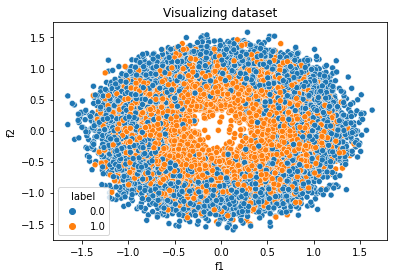

In [ ]:
plt.title("Visualizing dataset")
sns.scatterplot(x=data['f1'], y=data['f2'], hue=data['label'])
plt.show()

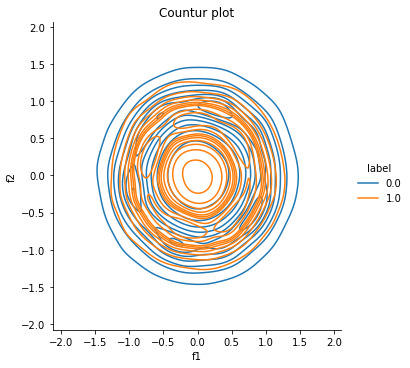

In [ ]:
sns.displot(x=data['f1'], y=data['f2'], hue=data['label'], kind='kde')
plt.title("Countur plot")
plt.show()

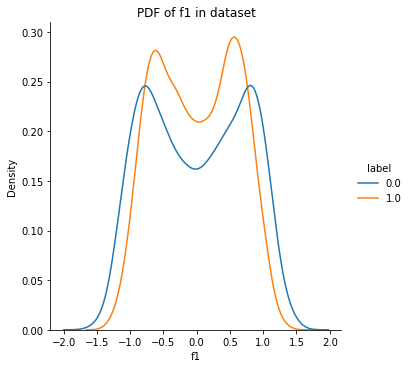

In [ ]:
sns.displot(data=data, x='f1', kind='kde', hue='label')
plt.title("PDF of f1 in dataset")
plt.show()

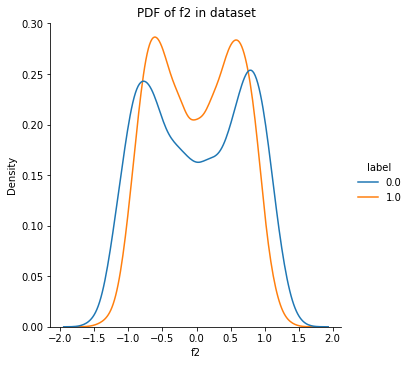

In [ ]:
sns.displot(data=data, x='f2', kind='kde', hue='label')
plt.title("PDF of f2 in dataset")
plt.show()

* From the `Visualizing dataset` plot, the data is a concentric circles and has a lots of noisy points with the less opportunity to find the valid decision boundery.
* From the `pdfs of f1 and f2 features and Countur plot`, the distributions of the **class 0** and **class 1** data points are overlaping.
* It becomes very difficult to classify the datapoints even using the powerfull neural network.